In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import utils

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test  = x_test  / 255.0

In [3]:
def reshape(data):
    return data.reshape(data.shape[0], 28, 28, 1)

x_train = reshape(x_train)
x_test = reshape(x_test)

x_train = np.array([utils.zoom_to_bounds(img_array) for img_array in x_train])
x_test = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test])

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [5]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.9066229 ,  0.45116362,  0.39297828,  1.0423465 ,  0.80897415,
        -1.557989  ,  0.02045135, -0.24013263, -0.7494539 , -0.6732521 ]],
      dtype=float32)

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.03500699, 0.13609244, 0.12839982, 0.24579974, 0.19463865,
        0.0182503 , 0.08846632, 0.06817228, 0.04096495, 0.04420856]],
      dtype=float32)

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [9]:
loss_fn(y_train[:1], predictions).numpy()

4.003574

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2920 - accuracy: 0.9137
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1507 - accuracy: 0.9553
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1179 - accuracy: 0.9646
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1033 - accuracy: 0.9688
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0920 - accuracy: 0.9717


In [12]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0803 - accuracy: 0.9757


[0.08032063394784927, 0.9757000207901001]

In [18]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [19]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(37, 28, 28, 1)

C:\Users\verst\AppData\Local\Temp/ipykernel_9028/1085257074.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


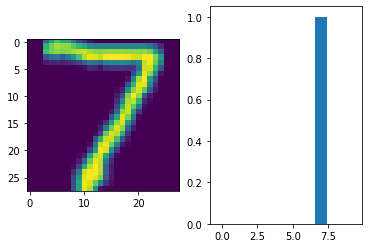

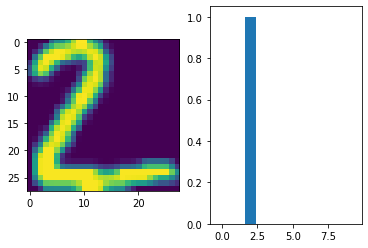

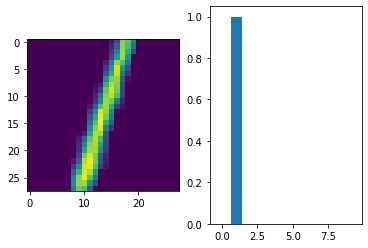

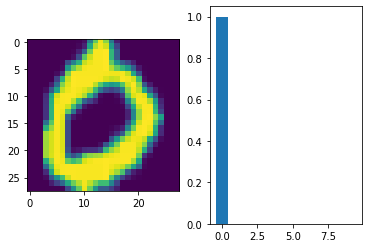

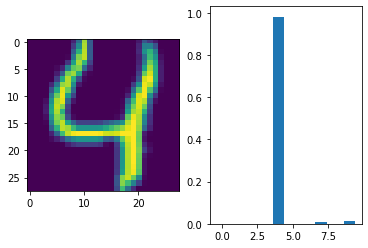

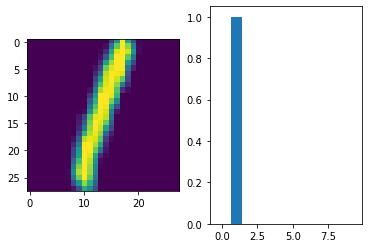

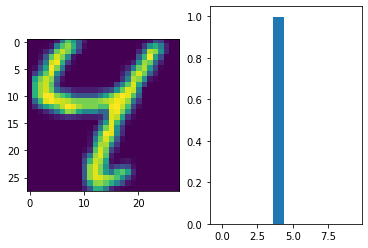

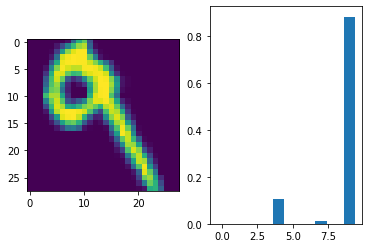

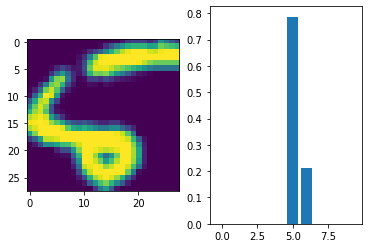

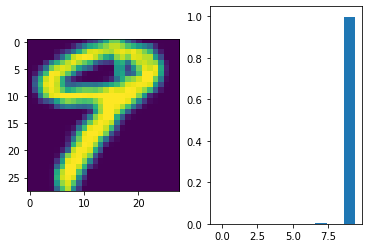

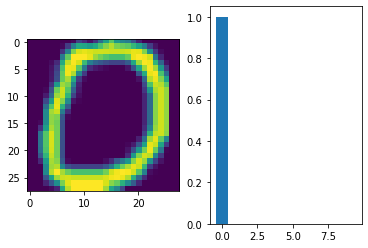

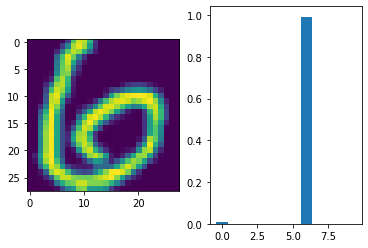

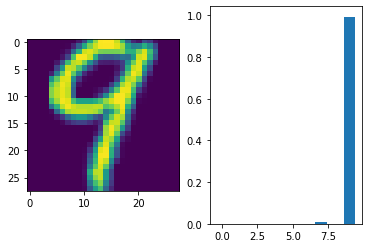

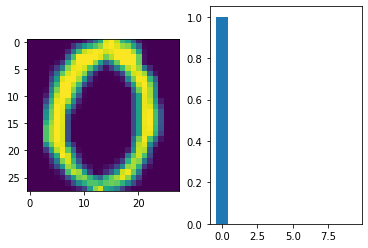

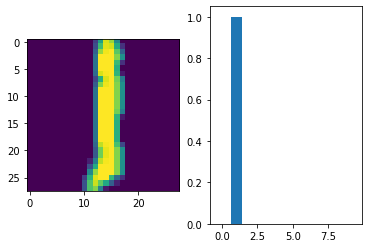

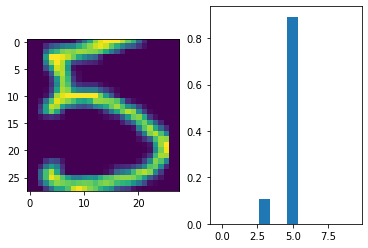

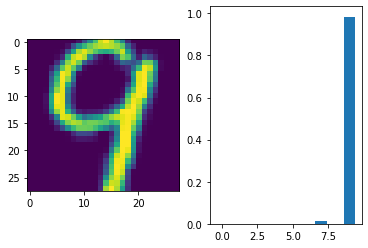

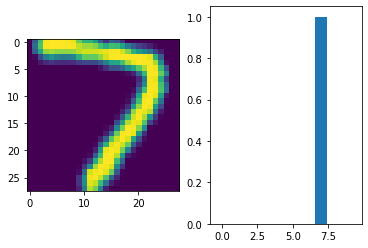

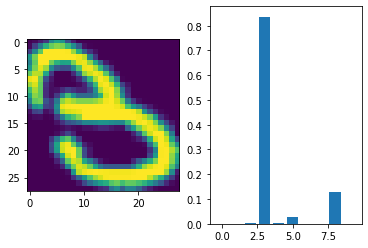

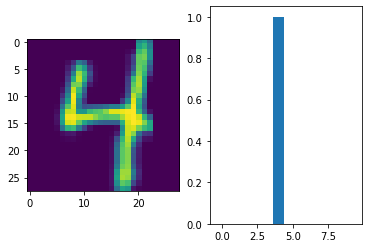

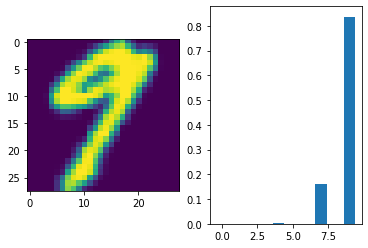

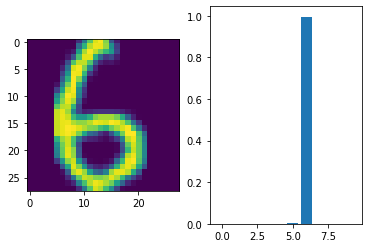

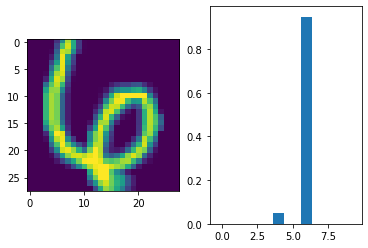

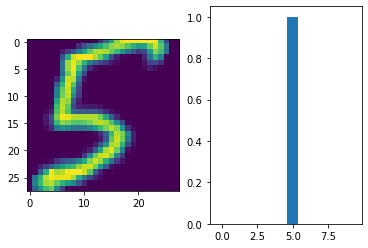

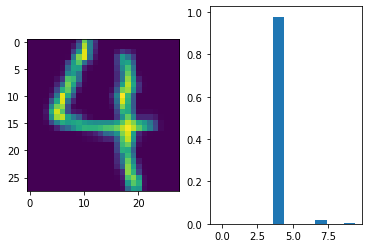

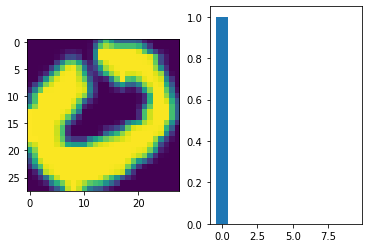

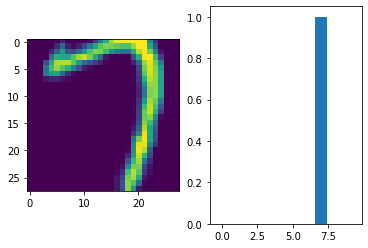

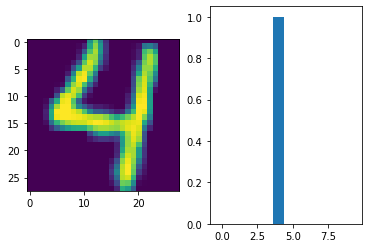

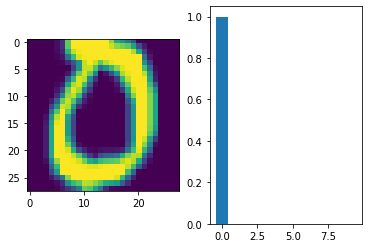

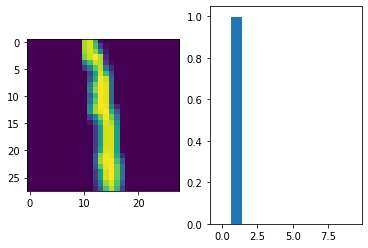

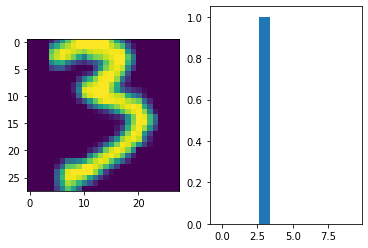

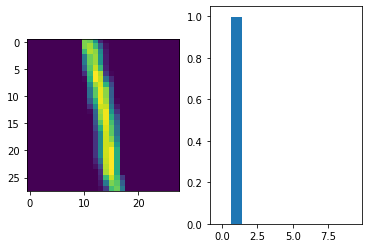

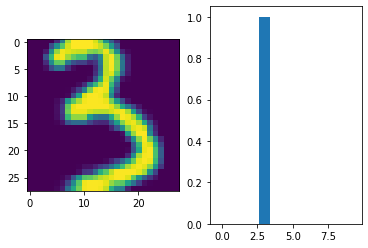

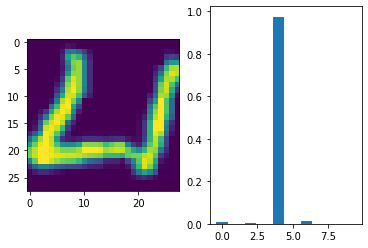

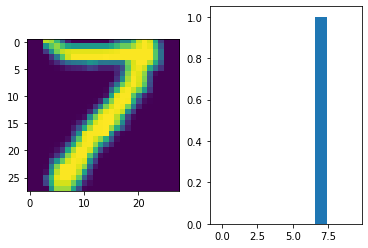

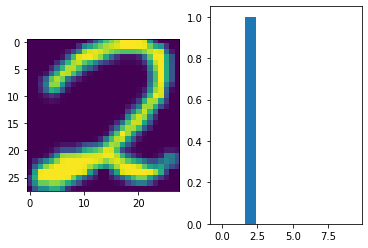

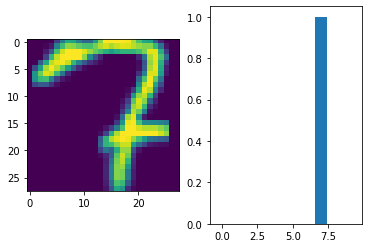

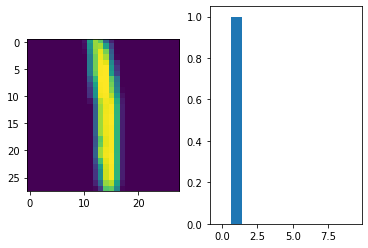

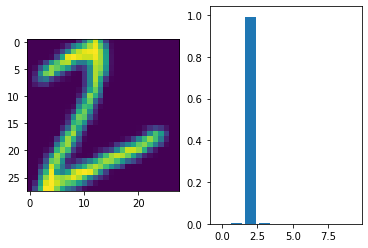

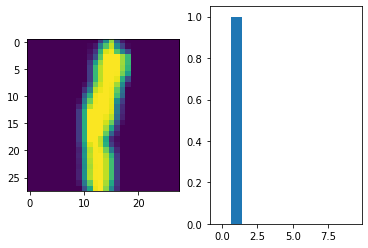

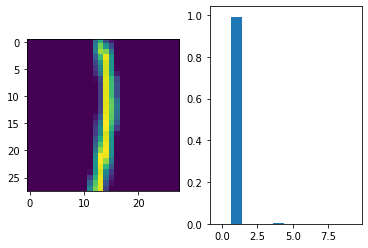

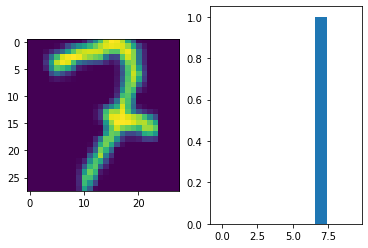

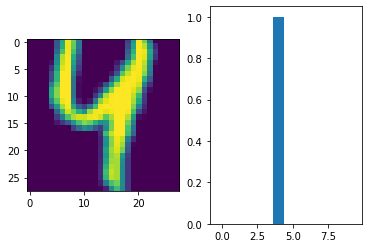

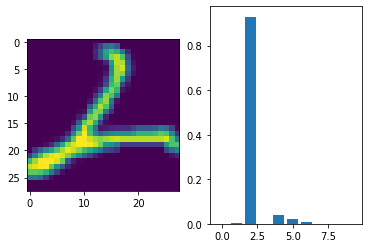

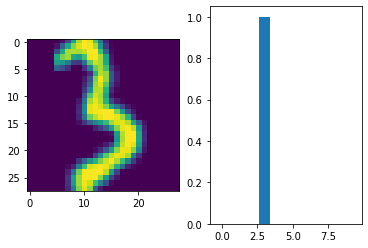

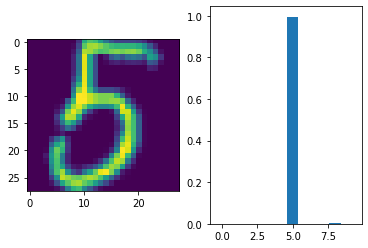

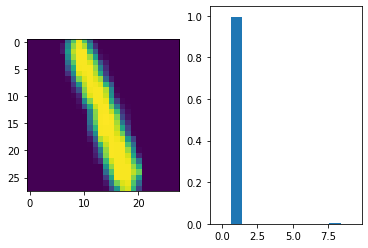

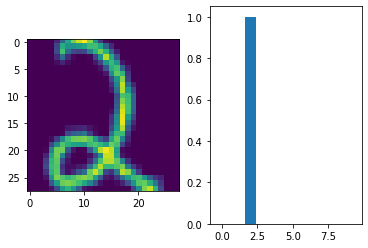

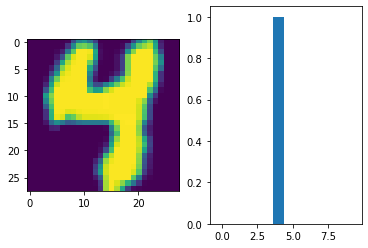

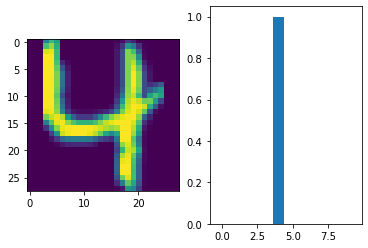

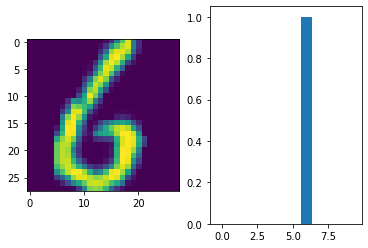

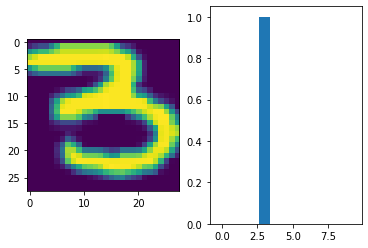

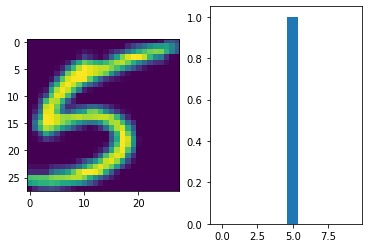

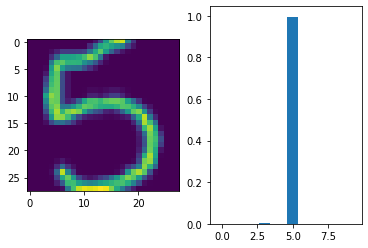

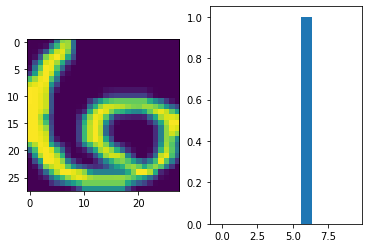

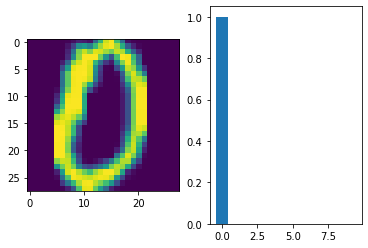

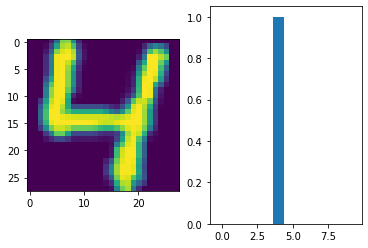

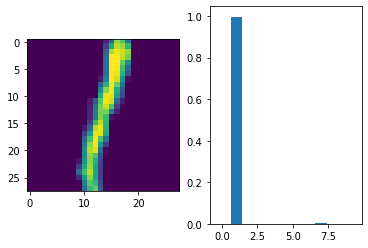

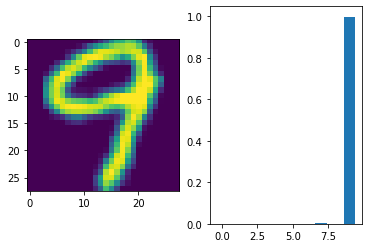

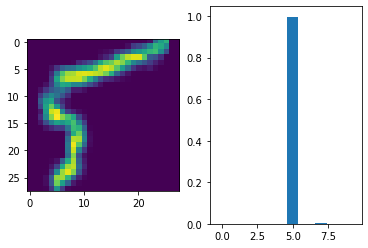

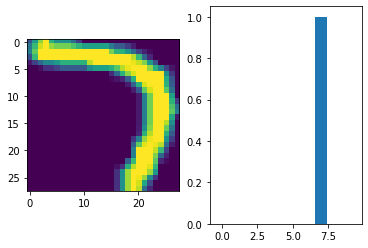

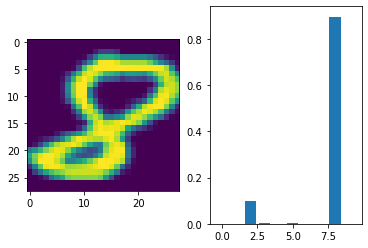

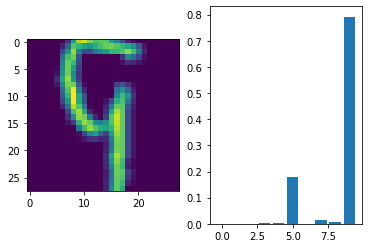

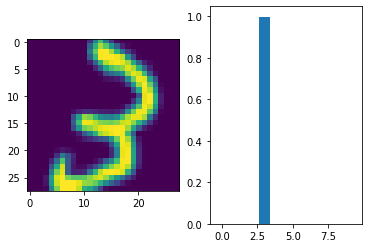

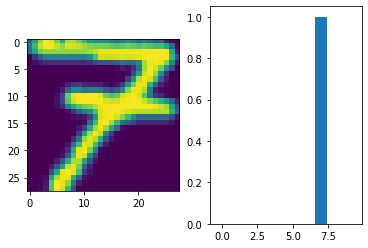

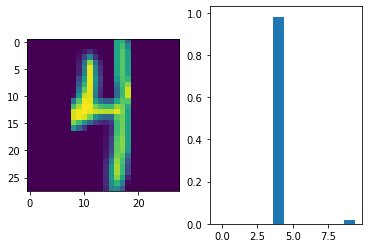

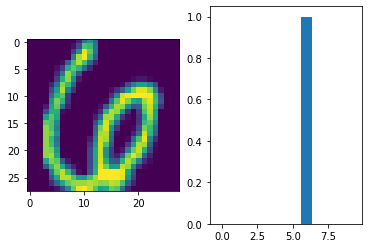

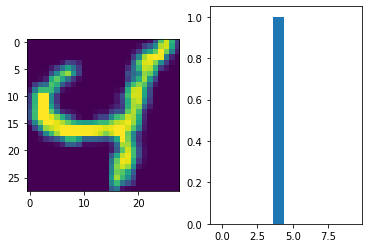

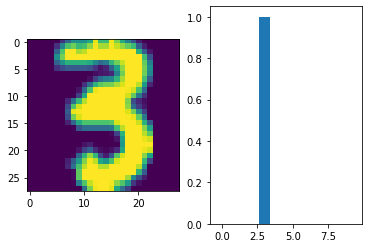

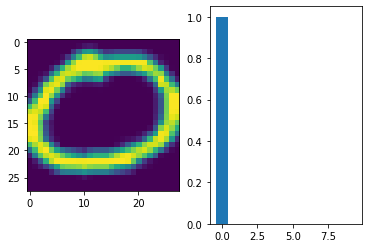

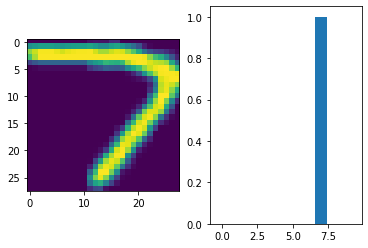

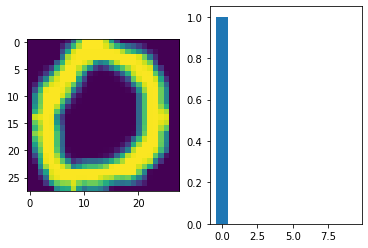

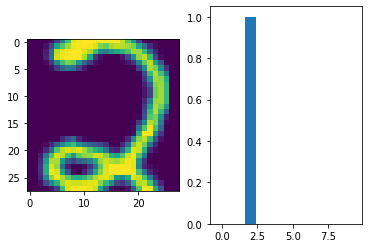

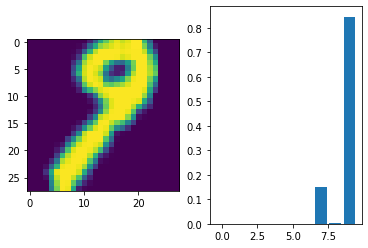

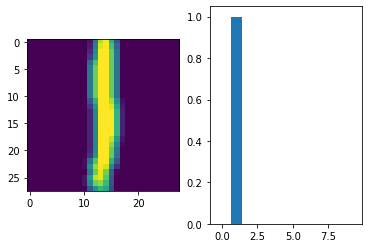

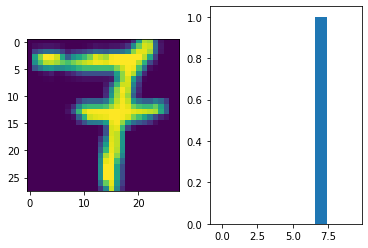

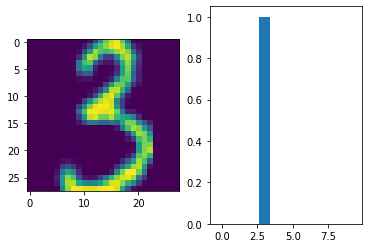

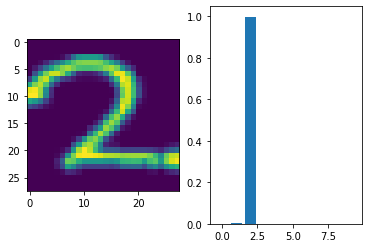

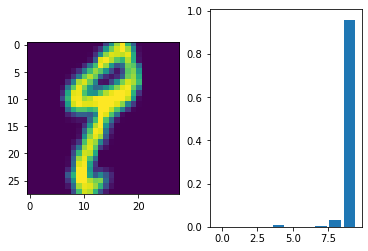

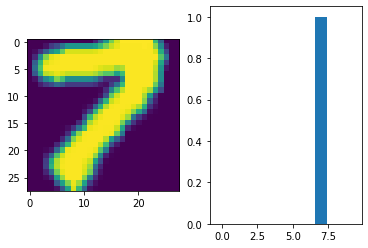

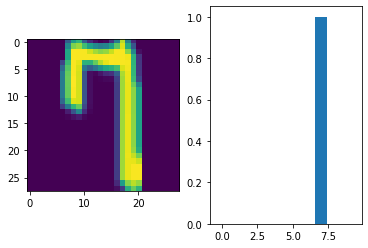

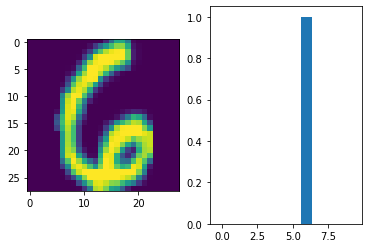

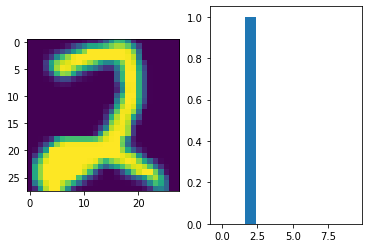

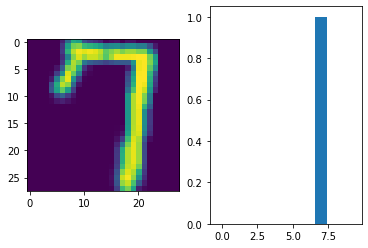

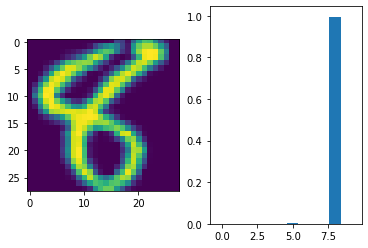

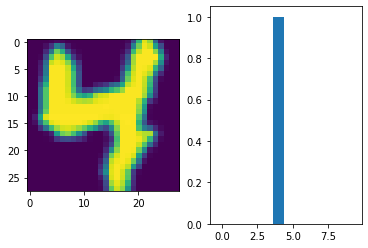

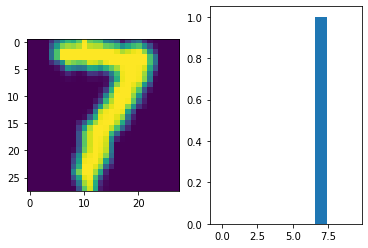

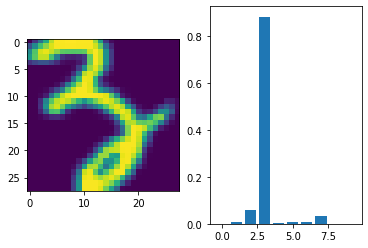

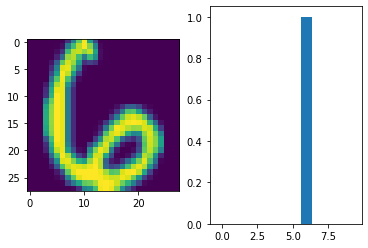

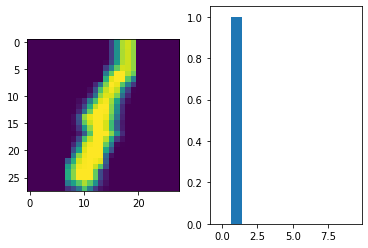

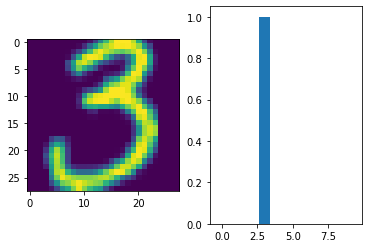

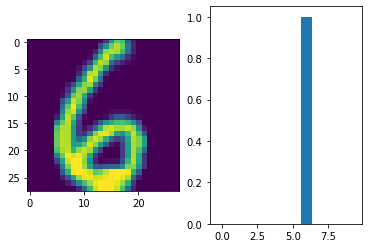

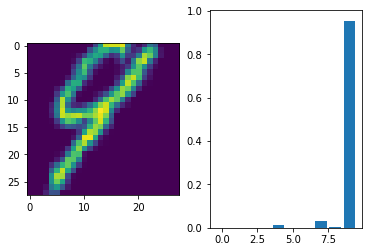

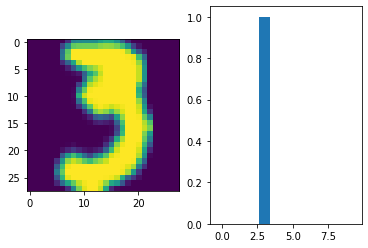

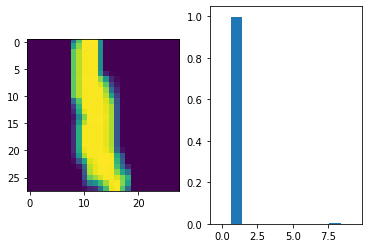

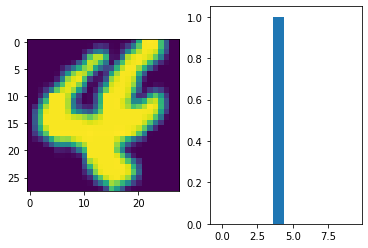

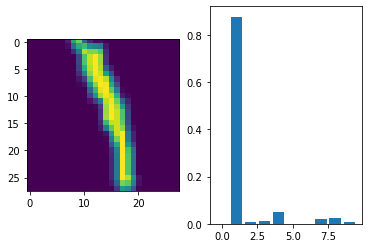

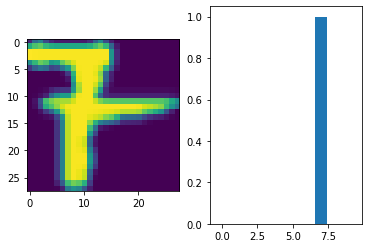

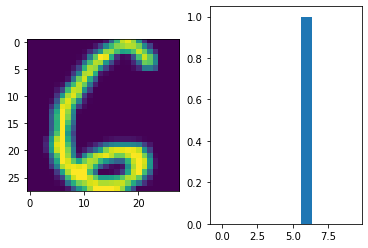

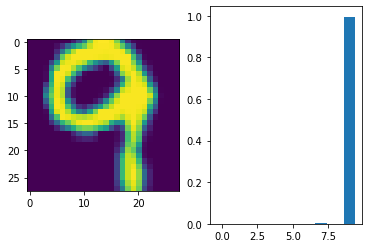

In [20]:
data = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test[:100]])
predictions = probability_model(data)
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.bar(x=range(0, 10), height=predictions[i])